In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.utils.tensorboard import SummaryWriter
import torch.utils.checkpoint as checkpoint

import matplotlib.pyplot as plt

from torchvision.io import read_image

import os
import nibabel as nib
import numpy as np
from torch.utils.data import Dataset

In [3]:
#Kernel size k x k x k
# 1. Depthwise Convolution with kernel size k × k × k
# 2. Normalization, with C output channels
#       We use channel-wise GroupNorm for stability with small
#       batches, instead of the original LayerNorm
class DepthwiseConv3d(nn.Module):
    def __init__(self, in_channels, kernel_size, padding=0, bias=False):
        super(DepthwiseConv3d, self).__init__()
        self.depthwise_conv = nn.Conv3d(in_channels, in_channels, 
                                        kernel_size=kernel_size, padding=padding, 
                                        groups=in_channels, bias=bias)
        self.norm = nn.GroupNorm(num_groups=in_channels, num_channels=in_channels)

    def forward(self, x):
        out = self.depthwise_conv(x)
        out = self.norm(out)
        return out


# Expansion layer contains:
# 1. An overcomplete Convolution Layer with CR output channels,
#       where R is the expansion ratio (expansion_ratio)
# 

class ExpansionLayer(nn.Module):
    def __init__(self, in_channels, expansion_ratio, kernel_size, stride, padding):
        super(ExpansionLayer, self).__init__()
        self.conv = nn.Conv3d(in_channels, in_channels * expansion_ratio, 
                              kernel_size, stride=stride, padding=padding, 
                              groups=in_channels)
        self.norm = nn.GroupNorm(num_groups=in_channels, num_channels=in_channels * expansion_ratio)
        self.activation = nn.GELU()

    def forward(self, x):
        out = self.conv(x)
        out = self.norm(out)
        out = self.activation(out)
        return out
    
# Compression layer:
# 1. 1×1×1 kernel and and C output channels performing channel-wise 
#       compression of the feature maps.
# 2. It can have 2xC or 0.5xC
class CompressionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CompressionLayer, self).__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [12]:
class ResidualLayer(nn.Module):
    def __init__(self, in_channels, kernel_size, expansion_ratio, out_channels, padding):
        super(ResidualLayer, self).__init__()
        stride = 2
        if in_channels == out_channels: stride = 1
        self.sampling_ratio = out_channels/in_channels
        
        self.depthwise_conv = DepthwiseConv3d(in_channels, kernel_size, padding)
        self.expansion_layer = ExpansionLayer(in_channels, expansion_ratio, 1, stride, padding)
        self.compression_layer = CompressionLayer(in_channels * expansion_ratio, out_channels)
        

        sampled_out_channels = in_channels
        # Layer only for sampling ratio not 1 
        if self.sampling_ratio != 1:
            if self.sampling_ratio == 2: sampled_out_channels = in_channels * 2
            else: sampled_out_channels = in_channels * 0.5

        sampled_out_channels = int(sampled_out_channels) # ALL THIS TIME IT GAVE ME AN ERROR 
        # BECAUSE OF THIS!!!!!!!!!!!!!!!!!!!!!

        # print (sampled_out_channels)
        self.conv_transpose = nn.Conv3d(in_channels, sampled_out_channels, 
                                        kernel_size = 1, stride=2)

        # self.block_expansion_ratio = out_channels/in_channels # It can have 2xC or 0.5xC

    def forward(self, x):
        out = self.depthwise_conv(x)
        #print ("dep layer", out.shape)
        out = self.expansion_layer(out)
        #print ("exp layer", out.shape)
        out = self.compression_layer(out)
        #print ("com layer", out.shape)

        #trimming the edges 
        dims = out.shape 
        if self.sampling_ratio == 1:
            out = out[:, :, 2:dims[2]-2, 2:dims[3]-2, 2:dims[4]-2]
        if self.sampling_ratio == 2 or self.sampling_ratio == 0.5:
            out = out[:, :, 1:dims[2]-1, 1:dims[3]-1, 1:dims[4]-1]
        print ("output shape (b, c, x, y, z)", out.shape)


        if self.sampling_ratio != 1:
            out += self.conv_transpose(x)
            return out
        else:
            out += x
            return out # Residual block (is it just sum)

In [5]:
# kernel size 5x5x5 - most effective
# Expansion Ratios: 
# R1 = R9 = 3
# R2 = R8 = 4
# R3-R7 = 8

# Number of blocks
# B1 = B9 = 3
# B2 = B8 = 4
# B3−7 = 8 

#stride = 1 if in == out, and 2 if in != out

# MedNeXt-B (5 × 5 × 5) + UpKern 84.23 87.06 89.38 92.36

kernel_size = 5

#B1 and B9 
class MedNeXtBlock_x3(nn.Module):
    def __init__(self, in_channels):
        super(MedNeXtBlock_x3, self).__init__()
        R1 = 3 # Expansion Ratio 
        self.l1 = ResidualLayer(in_channels, kernel_size, R1, in_channels, padding = (2, 2, 2))
        self.l2 = ResidualLayer(in_channels, kernel_size, R1, in_channels, padding = (2, 2, 2))
        self.l3 = ResidualLayer(in_channels, kernel_size, R1, in_channels, padding = (2, 2, 2))

    def forward(self, x):
        out = self.l1 (x)
        out = self.l2 (out)
        out = self.l3 (out)
        return out
        
#B2 and B8 
class MedNeXtBlock_x4(nn.Module):
    def __init__(self, in_channels):
        super(MedNeXtBlock_x4, self).__init__()
        R2 = 4 # Expansion Ratio 
        self.l1 = ResidualLayer(in_channels, kernel_size, R2, in_channels, padding = (2, 2, 2))
        self.l2 = ResidualLayer(in_channels, kernel_size, R2, in_channels, padding = (2, 2, 2))
        self.l3 = ResidualLayer(in_channels, kernel_size, R2, in_channels, padding = (2, 2, 2))
        self.l4 = ResidualLayer(in_channels, kernel_size, R2, in_channels, padding = (2, 2, 2))

    def forward(self, x):
        out = self.l1 (x)
        out = self.l2 (out)
        out = self.l3 (out)
        out = self.l4 (out)
        return out
    
#B3-B7
class MedNeXtBlock_x8(nn.Module):
    def __init__(self, in_channels):
        super(MedNeXtBlock_x8, self).__init__()
        R3 = 8 # Expansion Ratio 
        self.l1 = ResidualLayer(in_channels, kernel_size, R3, in_channels, padding = (2, 2, 2))
        self.l2 = ResidualLayer(in_channels, kernel_size, R3, in_channels, padding = (2, 2, 2))
        self.l3 = ResidualLayer(in_channels, kernel_size, R3, in_channels, padding = (2, 2, 2))
        self.l4 = ResidualLayer(in_channels, kernel_size, R3, in_channels, padding = (2, 2, 2))
        self.l5 = ResidualLayer(in_channels, kernel_size, R3, in_channels, padding = (2, 2, 2))
        self.l6 = ResidualLayer(in_channels, kernel_size, R3, in_channels, padding = (2, 2, 2))
        self.l7 = ResidualLayer(in_channels, kernel_size, R3, in_channels, padding = (2, 2, 2))
        self.l8 = ResidualLayer(in_channels, kernel_size, R3, in_channels, padding = (2, 2, 2))

    def forward(self, x):
        out = self.l1 (x)
        out = self.l2 (out)
        out = self.l3 (out)
        out = self.l4 (out)
        out = self.l5 (out)
        out = self.l6 (out)
        out = self.l7 (out)
        out = self.l8 (out)
        return out
    

In [6]:
# Expansion Ratios: 
# R1 = R9 = 3
# R2 = R8 = 4
# R3-R7 = 8

# Number of blocks
# B1 = B9 = 3
# B2 = B8 = 4
# B3−7 = 8 

class MedNeXt(nn.Module):
    def __init__(self, in_channels):
        super(MedNeXt, self).__init__()
        # Expansion Ratios
        R1 = 3 # R9
        R2 = 4 # R8
        R3 = 8 # R3-R7
        C = in_channels

        # Encoder
        self.l1 = MedNeXtBlock_x3 (C)
        self.l2 = ResidualLayer(C, kernel_size, R2, C*2, padding = (2, 2, 2)) # Down 2x
        self.l3 = MedNeXtBlock_x4 (C*2)
        self.l4 = ResidualLayer(C*2, kernel_size, R3, C*4, padding = (2, 2, 2)) # Down 2x
        self.l5 = MedNeXtBlock_x8 (C*4)
        self.l6 = ResidualLayer(C*4, kernel_size, R3, C*8, padding = (2, 2, 2)) # Down 2x
        self.l7 = MedNeXtBlock_x8 (C*8)
        self.l8 = ResidualLayer(C*8, kernel_size, R3, C*16, padding = (2, 2, 2)) # Down 2x

        # Bottleneck
        self.bottleneck = ResidualLayer(C*16, kernel_size, R3, C*16, padding = (2, 2, 2))

        # Decoder
        self.l9 = ResidualLayer(C*16, kernel_size, R3, C*8, padding = (2, 2, 2)) # Up 2x
        self.l10 = MedNeXtBlock_x8 (C*8)
        self.l11 = ResidualLayer(C*8, kernel_size, R3, C*4, padding = (2, 2, 2)) # Up 2x
        self.l12 = MedNeXtBlock_x8 (C*4)
        self.l11 = ResidualLayer(C*4, kernel_size, R3, C*2, padding = (2, 2, 2)) # Up 2x
        self.l12 = MedNeXtBlock_x4 (C*2)
        self.l11 = ResidualLayer(C*2, kernel_size, R2, C*1, padding = (2, 2, 2)) # Up 2x
        self.l12 = MedNeXtBlock_x3 (C)

    def forward(self, x):
        mainoutput = self.l1(x)
        out1 = mainoutput

        mainoutput = self.l2(mainoutput)
        mainoutput = self.l3(mainoutput)
        out3 = mainoutput

        mainoutput = self.l4(mainoutput)
        mainoutput = self.l5(mainoutput)
        out5 = mainoutput

        mainoutput = self.l6(mainoutput)
        mainoutput = self.l7(mainoutput)
        out7 = mainoutput

        mainoutput = self.l8(mainoutput)

        mainoutput = self.bottleneck(mainoutput)

        mainoutput = self.l9(mainoutput)
        mainoutput += out7
        mainoutput = self.l10(mainoutput)

        mainoutput = self.l11(mainoutput)
        mainoutput += out5
        mainoutput = self.l12(mainoutput)

        mainoutput = self.l13(mainoutput)
        mainoutput += out3
        mainoutput = self.l14(mainoutput)

        mainoutput = self.l15(mainoutput)
        mainoutput += out1 
        mainoutput = self.l16(mainoutput)

        return mainoutput

(240, 240)


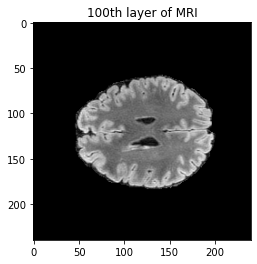

In [7]:
# Test the dataset
# Printing the MRI of the first patient

data = nib.load("C:/Users/alist/WorkCodes/Datasets/BRATS2021TRAINDATASET/BraTS2021_00000/BraTS2021_00000_flair.nii.gz")
image = data.get_fdata()
slice_data = image[:, :, 100]
print (slice_data.shape)

plt.imshow(slice_data, cmap='gray')
plt.title("100th layer of MRI")
plt.show()

In [8]:
class BraTS2021Dataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.patient_ids = os.listdir(data_dir)

    def __len__(self):
        return len(self.patient_ids)

    def __getitem__(self, idx):
        patient_id = self.patient_ids[idx]
        scan_files = [os.path.join(self.data_dir, patient_id, f'{patient_id}_{modality}.nii.gz')
                      for modality in ['t1', 't2', 't1ce', 'flair']]
        mask_file = os.path.join(self.data_dir, patient_id, f'{patient_id}_seg.nii.gz')

        # Load scan files and concatenate into a 4-channel tensor
        # In the BraTS dataset specifically, each patient has four MRI scans available: 
        # T1-weighted, T1-weighted with contrast enhancement (T1ce), T2-weighted, and FLAIR. 
        # By concatenating these four scans into a single 4-channel tensor, we can provide 
        # the model with more information about the anatomy being imaged.
        
        scans = []
        for scan_file in scan_files:
            scan_data = nib.load(scan_file).get_fdata()
            scans.append(scan_data)
        scans_tensor = np.stack(scans, axis=0)
        
        # Load mask file and convert to integer labels
        mask_data = nib.load(mask_file).get_fdata()
        mask_tensor = (mask_data > 0).astype(np.int64) + (mask_data == 4).astype(np.int64) * 2
        
        # Normalize scans and convert to PyTorch tensor
        scans_tensor -= np.mean(scans_tensor)
        scans_tensor /= np.std(scans_tensor)
        scans_tensor = torch.from_numpy(scans_tensor).float()
        
        # Convert mask to PyTorch tensor
        mask_tensor = torch.from_numpy(mask_tensor).long()
        
        return scans_tensor, mask_tensor

Scan tensor shape: torch.Size([4, 240, 240, 155])
Mask tensor shape: torch.Size([240, 240, 155])


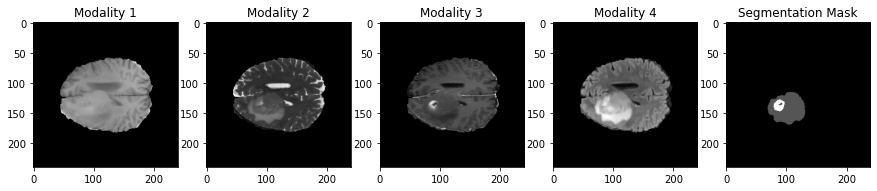

In [9]:
# Test the dataset

data_dir = 'C:/Users/alist/WorkCodes/Datasets/BRATS2021TRAINDATASET'
dataset = BraTS2021Dataset(data_dir)

# Load a single patient's MRI scan and segmentation mask
patient_idx = 1
scan, mask = dataset[patient_idx]

# Print shape of scan and mask tensors
print('Scan tensor shape:', scan.shape)
print('Mask tensor shape:', mask.shape)

# Visualize the scan and mask using matplotlib
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for i in range(4):
    axs[i].imshow(scan[i][:, :, 100], cmap='gray')
    axs[i].set_title(f'Modality {i+1}')
axs[4].imshow(mask[:, :, 100], cmap='gray')
axs[4].set_title('Segmentation Mask')
plt.show()

In [10]:
import torch.utils.data

# Define split sizes
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Split the whole dataset into train and test dataset. Is validation needed?
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [22]:
print(f"Current GPU memory usage: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")

Current GPU memory usage: 15490.32 MB


In [15]:
"""test1 = ExpansionLayer(4, 8, kernel_size, stride=1, padding = (1,1,1))

test1(x)"""


"""testtest = ResidualLayer(4, kernel_size, 4, 2, padding = 2).to(device)
testtest (x)"""

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.randn(1, 4, 240, 240, 155).to(device) #batch size, channels, x, y, z



test_model = MedNeXt(4).to(device)
test_model(x)





OutOfMemoryError: CUDA out of memory. Tried to allocate 138.00 MiB (GPU 0; 16.00 GiB total capacity; 15.13 GiB already allocated; 0 bytes free; 15.23 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MedNeXt(4).to(device)

if torch.cuda.is_available():
    device = torch.cuda.get_device_name(0)
    print('My GPU is correctly configured. GPU device name:', device)
else:
    print('No GPU available')

# Define hyperparameters
batch_size = 1
learning_rate = 0.05
num_epochs = 1

# Define dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss() # Is not specified but typically this
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# writer for summaries
writer = SummaryWriter('runs/mednext_brats')

for epoch in range(num_epochs):
    
    running_loss = 0.0
    
    for i, (images, labels) in enumerate(train_loader):
        
        # move the data to the GPU. Gives an error otherwise lol
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        images = images.to(device)
        labels = labels.to(device)

        print (images.shape, labels.shape)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            writer.add_scalar('training loss', running_loss / 100, epoch * len(train_loader) + i)
            running_loss = 0.0
            
    # save checkpoint
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': running_loss,
    },  'checkpoint.pth')
    
    # validation loop
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 251 test images: %d %%' % (
        100 * correct / total))
    writer.add_scalar('validation accuracy', 100 * correct / total, epoch)

My GPU is correctly configured. GPU device name: NVIDIA GeForce RTX 3080 Laptop GPU
torch.Size([1, 4, 240, 240, 155]) torch.Size([1, 240, 240, 155])
dep layer torch.Size([1, 4, 240, 240, 155])


OutOfMemoryError: CUDA out of memory. Tried to allocate 434.00 MiB (GPU 0; 16.00 GiB total capacity; 14.99 GiB already allocated; 0 bytes free; 15.04 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
def gelu(x):
    """Implementation of the gelu activation function."""
    return x * torch.sigmoid(1.702 * x)

In [2]:
class DepthwiseConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(DepthwiseConv2d, self).__init__()
        self.depthwise_conv = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=stride,
                                        padding=padding, groups=in_channels)
        self.bn = nn.BatchNorm2d(in_channels)
        self.pointwise_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.depthwise_conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.pointwise_conv(x)
        x = self.relu(x)
        return x


In [4]:
train_dataset = datasets.CIFAR10(root='./data', train=True, 
                                 download=True, transform=transforms.ToTensor())
test_dataset = datasets.CIFAR10(root='./data', train=False, 
                                download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified
